# **Cài đặt thư viện**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub, os, time, joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample

# **Tải dataset**

In [2]:
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

csv_path = os.path.join(path, "HAM10000_metadata.csv")
data = pd.read_csv(csv_path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.


In [3]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
data.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


# **Preprocessing**

In [6]:
# Fill dữ liệu bị thiếu
imputer = SimpleImputer(strategy="median")
data["age"] = imputer.fit_transform(data[["age"]])

In [7]:
data.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0


In [8]:
# Mapping cột dx thành diagnosis
dx_dict = {
    'mel': 'melanoma',
    'nv': 'nevus',
    'bkl': 'benign keratosis-like lesions',
    'bcc': 'basal cell carcinoma',
    'akiec': 'actinic keratoses',
    'vasc': 'vascular lesions',
    'df': 'dermatofibroma'
}
data["diagnosis"] = data["dx"].map(dx_dict)

In [9]:
data


,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,benign keratosis-like lesions
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,actinic keratoses
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,actinic keratoses
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,actinic keratoses
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,actinic keratoses


<Axes: xlabel='diagnosis'>

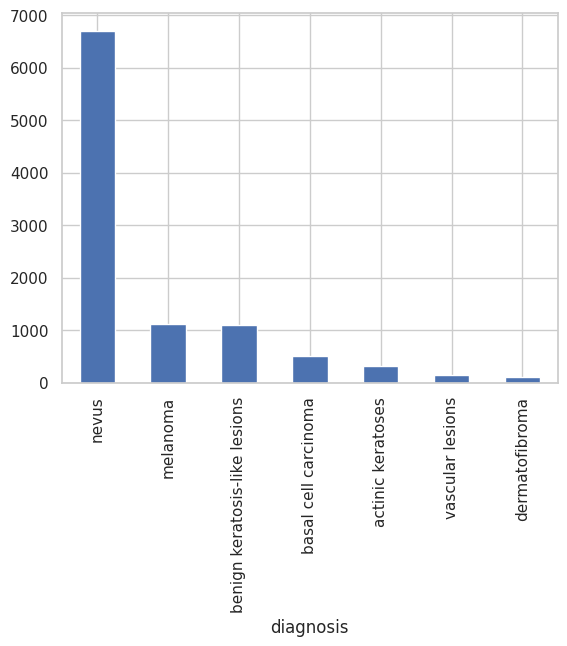

In [10]:
data['diagnosis'].value_counts().plot(kind='bar')

<Axes: xlabel='age', ylabel='diagnosis'>

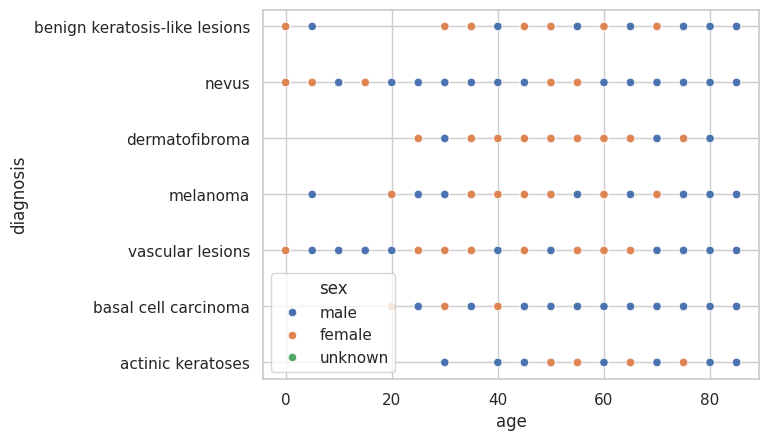

In [44]:
sns.scatterplot(x='age', y='diagnosis', hue='sex', data=data)

In [11]:
le_sex = LabelEncoder()
le_loc = LabelEncoder()

data["sex_enc"] = le_sex.fit_transform(data["sex"])
data["localization_enc"] = le_loc.fit_transform(data["localization"])

In [12]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,sex_enc,localization_enc
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,1,11
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,1,11
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,1,11
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,1,11
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,benign keratosis-like lesions,1,4
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,actinic keratoses,1,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,actinic keratoses,1,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,actinic keratoses,1,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,actinic keratoses,1,5


# **BINARY CLASSIFICATION: Melanoma vs Benign**

## **Xử lý mất cân bằng dữ liệu**

In [51]:
# Label 1 (B = malignant / ác tính) → ["mel", "bcc", "akiec", "vasc"]
# Label 0 (M = benign / lành tính) → ["nv", "df", "bkl"]
malignant = ["mel", "bcc", "akiec", "vasc"]
data["binary_label"] = data["dx"].apply(lambda x: 1 if x in malignant else 0)

In [52]:
data_majority = data[data["binary_label"] == 0]
data_minority = data[data["binary_label"] == 1]

In [53]:
data["binary_label"].value_counts()

,count
binary_label,
0,7919
1,2096


In [54]:
data_minority_upsampled = resample(
    data_minority,
    replace=True,
    n_samples=len(data_majority),
    random_state=42
)
data_balanced_bin = pd.concat([data_majority, data_minority_upsampled])

In [55]:
data_balanced_bin["binary_label"].value_counts()

,count
binary_label,
0,7919
1,7919


In [57]:
# Giữ lại các cột có tác động trực tiếp đến mô hình
X_bin = data_balanced_bin[["age", "sex_enc", "localization_enc"]]
y_bin = data_balanced_bin["binary_label"]

## **Tách tập train và test**

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

In [59]:
scaler = StandardScaler()
X_bin_train = scaler.fit_transform(X_train)
X_bin_test = scaler.transform(X_test)

In [60]:
# Tìm siêu tham số

# param_grid = {
#     'C': [0.1, 1, 10, 50],
#     'gamma': ['scale', 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }

# grid_bin = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_bin.fit(X_train, y_train)

# print("Best params:", grid_bin.best_params_)
# svm_bin = SVC(**grid_bin.best_params_)

In [61]:
# Best params: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [62]:
svm_bin = SVC(kernel='rbf', C=50, gamma='scale')

In [63]:
svm_bin.fit(X_bin_train, y_train)

SVC(C=50)

## **Đánh giá mô hình**

In [64]:
# Với việc dữ liệu bị mất cân bằng giữa 2 lớp -> nếu không xử lý mất cân bằng thì accuracy cao hơn (10 - 15%) nhưng các chỉ số precision, recall lệch về lớp có nhiều dữ liệu đào tạo hơn
y_pred_bin = svm_bin.predict(X_bin_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred_bin))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bin))


Accuracy: 0.6994949494949495

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      1573
           1       0.70      0.70      0.70      1595

    accuracy                           0.70      3168
   macro avg       0.70      0.70      0.70      3168
weighted avg       0.70      0.70      0.70      3168



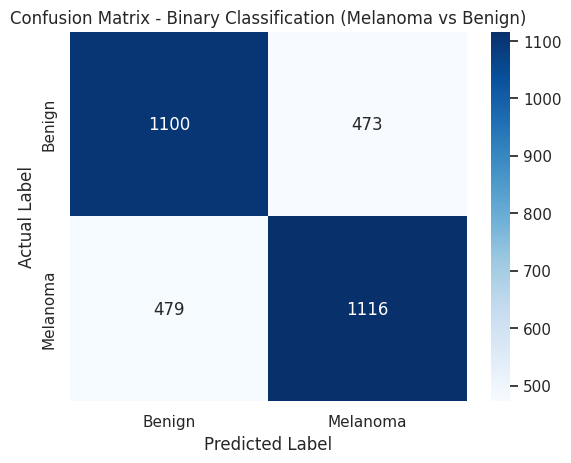

In [65]:
cm = confusion_matrix(y_test, y_pred_bin)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Melanoma"],
            yticklabels=["Benign", "Melanoma"])

plt.title("Confusion Matrix - Binary Classification (Melanoma vs Benign)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# **MULTI-CLASS CLASSIFICATION**
Em có thử với mô hình SVM thì việc chỉ sử dụng dataset csv không trích xuất thêm đặc trưng từ ảnh thì việc phân loại nhiều class sẽ không thể đạt được accuracy tối ưu

In [ ]:
data["diagnosis"].value_counts()

,count
diagnosis,
nevus,6705
melanoma,1113
benign keratosis-like lesions,1099
basal cell carcinoma,514
actinic keratoses,327
vascular lesions,142
dermatofibroma,115


In [ ]:
#OverSampling
data_majority = max(data["diagnosis_enc"].value_counts())
replace = True

# UnderSampling
# data_minority = min(data["diagnosis_enc"].value_counts())
# replace = False
balanced_data = []

for label in data["diagnosis_enc"].unique():
    subset = data[data["diagnosis_enc"] == label]
    resampled = resample(subset, replace=True, n_samples=data_majority, random_state=42)
    balanced_data.append(resampled)

data_balanced_multi = pd.concat(balanced_data)

In [ ]:
data_balanced_multi["diagnosis"].value_counts()

,count
diagnosis,
benign keratosis-like lesions,6705
nevus,6705
dermatofibroma,6705
melanoma,6705
vascular lesions,6705
basal cell carcinoma,6705
actinic keratoses,6705


## **Processing data**

In [ ]:
X_multi = data_balanced_multi[["age", "sex_enc", "localization_enc"]]
y_multi = data_balanced_multi["diagnosis_enc"]

In [ ]:
scaler_multi = MinMaxScaler()
X_multi_scaled = scaler_multi.fit_transform(X_multi)

X_train, X_test, y_train, y_test = train_test_split(X_multi_scaled, y_multi, test_size=0.2, random_state=42)

## **Grid search**

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10, 50],
#     'gamma': ['scale', 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }

# grid_multi = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_multi.fit(X_train, y_train)


## **Huấn luyện mô hình**

In [ ]:
# svm_multi = SVC(**grid_multi.best_params_)
svm_multi = SVC(kernel='rbf', C=50, gamma="scale")

In [ ]:
start = time.time()
svm_multi.fit(X_train, y_train)
end = time.time()
print(f"Time: {end - start:.2f} giây")

Time: 282.04 giây


## **Evaluation**

In [ ]:
y_pred_multi = svm_multi.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred_multi))
print("\nClassification Report:\n", classification_report(y_test, y_pred_multi, target_names=le_dx.classes_))


Accuracy: 0.3167701863354037

Classification Report:
                                precision    recall  f1-score   support

            actinic keratoses       0.31      0.38      0.34        29
         basal cell carcinoma       0.32      0.48      0.38        21
benign keratosis-like lesions       0.33      0.04      0.07        27
               dermatofibroma       0.34      0.70      0.46        20
                     melanoma       0.31      0.18      0.23        22
                        nevus       0.25      0.30      0.27        20
             vascular lesions       0.38      0.23      0.29        22

                     accuracy                           0.32       161
                    macro avg       0.32      0.33      0.29       161
                 weighted avg       0.32      0.32      0.28       161



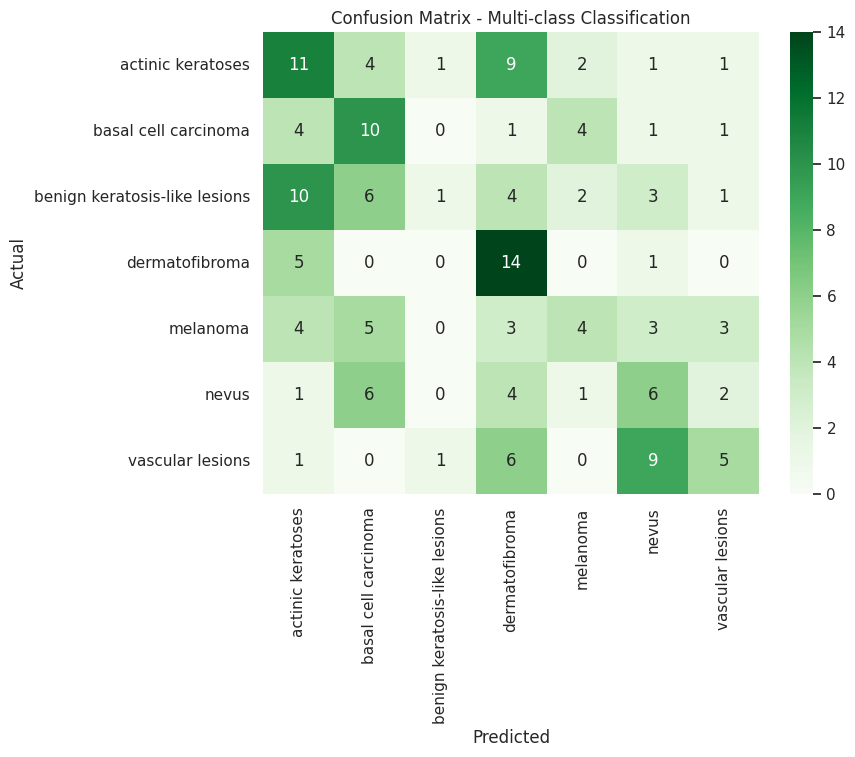

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_multi),
            annot=True, fmt="d", cmap="Greens",
            xticklabels=le_dx.classes_, yticklabels=le_dx.classes_)
plt.title("Confusion Matrix - Multi-class Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Lưu mô hình**

In [46]:
joblib.dump(svm_bin, "svm_binary_skin_cancer.pkl")
# joblib.dump(svm_multi, "svm_multiclass_skin_cancer.pkl")

['svm_binary_skin_cancer.pkl']